# 1. Using OpenAlex to find taxonomists

## 1.1. Retrieving articles from taxonomic journals

The OpenAlex API was used to retrieve all recent (last 10 years) articles published in specific journals. These journals were selected using SPARQL on Wikidata, with subjects such as "taxonomy", "phylogeny", "systematics" and "biological nomenclature", as well as manually adding missing journals. The resulting OpenAlex article data contains information on the authors and associated institutions, publishers, and abstract, among other things.

In [1]:
import requests
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pickle
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

## Functions

In [2]:
def request_pubs_openalex(category, openalex_id, other_id=False):
    publications = requests.get("https://api.openalex.org/works?cursor=*&per-page=200&filter=from_publication_date:2013-01-01,"
                                +category+openalex_id)
    
    if not other_id:
        query_name = requests.get("https://api.openalex.org/"+openalex_id).json()["display_name"]
        print("Number of publications associated with \""+query_name+
              "\": "+str(publications.json()["meta"]["count"]))
    
    next_pubs = publications.json()
    next_cursor = next_pubs["meta"]["next_cursor"]

    publications_results = next_pubs["results"]

    while next_pubs["meta"]["next_cursor"] != None:
        # get next page
        next_pubs = requests.get("https://api.openalex.org/works?per-page=200&filter=from_publication_date:2013-01-01,"
                                 +category+openalex_id+"&cursor="+next_cursor)

        next_pubs = next_pubs.json()
        next_cursor = next_pubs["meta"]["next_cursor"] # remember next cursor

        # add new results to total
        publications_results.extend(next_pubs["results"])
    
    publications_df = pd.DataFrame.from_dict(publications_results)
    return publications_df

In [21]:
def search_pubs_openalex(query):
    publications = requests.get("https://api.openalex.org/works?cursor=*&per-page=200"
                                +"&filter=from_publication_date:2013-01-01"
                                +"&search="
                                +query)
    
    next_pubs = publications.json()
    next_cursor = next_pubs["meta"]["next_cursor"]

    publications_results = next_pubs["results"]

    while next_pubs["meta"]["next_cursor"] != None:
        # get next page
        next_pubs = requests.get("https://api.openalex.org/works?"
                                +"filter=from_publication_date:2013-01-01"
                                +"&search="
                                +query+"&cursor="+next_cursor)

        next_pubs = next_pubs.json()
        next_cursor = next_pubs["meta"]["next_cursor"] # remember next cursor

        # add new results to total
        publications_results.extend(next_pubs["results"])
    
    publications_df = pd.DataFrame.from_dict(publications_results)
    return publications_df

In [3]:
# exclude additional words from wordclouds
stopwords = STOPWORDS
stopwords.update(["one", "two", "three", "four", "five", "et"]
                 +list("abcdefghijklmnopqrstuvwxyz1234567890.,;"))

In [4]:
def wordcloud_abstracts_json(df, name):
    abstract_words = df["abstract_inverted_index"]
    abstract_words = list(filter(None, abstract_words))
    
    frequencies = {}
    
    for pub in abstract_words:
        for word, indices in pub.items():
            word = word.strip(".")
            # add new word to frequencies
            if word in frequencies:
                frequencies[word] += len(indices)
            # add new words that are not stopwords
            elif word.lower() not in stopwords: 
                frequencies[word] = len(indices)
    
    # make wordcloud of abstract word frequencies
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").fit_words(frequencies)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # save wordcloud for this concept
    plt.savefig("./figures/wordcloud_"+name+".png", format="png")

    plt.show()

In [5]:
# enable SPARQLE queries (code from WikiData's query service)
endpoint_url = "https://query.wikidata.org/sparql"

def get_sparql_results(query, endpoint_url=endpoint_url):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return pd.DataFrame.from_dict(results["results"]["bindings"])

In [6]:
# get publications from last 10 years, published in list of journals via OpenAlex API
def search_issn_from_sparql(df):
    all_journals = pd.DataFrame()

    # get list of unique issn-l's
    all_issn_l = set()
    for issn_l in df["issn_l"]:
        test = requests.get("https://api.openalex.org/works?filter=from_publication_date:2013-01-01,host_venue.issn:"
                            +issn_l["value"])
        # exclude journals on which OpenAlex has no (recent) data
        if not test.json()["results"] == []:
            all_issn_l.add(issn_l["value"])

    print(all_issn_l)

    for issn in all_issn_l: 
        # issn-l is always the same as one of several issn's referring to the same journal
        # but issn-l is not searchable in openAlex
        journal_df = request_pubs_openalex("host_venue.issn:", issn, other_id=True)
        print(issn+" aka "+journal_df["host_venue"][0]["display_name"]+": done")

        all_journals = pd.concat([all_journals, journal_df])

    all_journals.reset_index(inplace=True)
    return all_journals

In [7]:
def build_query_subjects(list):
    # first specify instance of = scientific or academic journal
    query = """SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {
    ?item wdt:P236 ?issn.
    ?item wdt:P7363 ?issn_l.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      {
        ?item p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.
      }
      UNION
      {
        ?item p:P31 ?statement1.
        ?statement1 (ps:P31/(wdt:P279*)) wd:Q737498.
      }"""
    
    for i, subject in enumerate(list):
        i = 2 + i*2
        addition = """\n      {
        ?item p:P921 ?statement""" + str(i) + """.
        ?statement""" + str(i) + """ (ps:P921/(wdt:P279*)) wd:""" + subject + """.
      }
      UNION
      {
        ?item p:P101 ?statement""" + str(i+1) + """.
        ?statement""" + str(i+1) + """ (ps:P101/(wdt:P279*)) wd:""" + subject + """.
      }"""
        if i != 2:
            addition = "\n      UNION" + addition
        
        query += addition
    
    query += """\n    }
  }
}"""
    return query

## Results

To-do: 
- use "field of work" instead of "main subject",
- "acadamic journal" as well as "scientific journal"

To-do:
- include "botany" as main subject, 
- other main subjects such as entymology, mycology and zoology

Tried botany, mycology, and zoology together, but there are too many hits (many of them unrelated to taxonomy sensu strictu). Botany on its own includes many agricultural journals which distract from our goal.

To-do:
- include "biological classification" as a main subject (adds some results!)
- include other similar categories (plant-specific or not): "systematics", "plant taxonomy", "animal taxonomy" (adds many results!)
- (classification of birds)
- query for subclasses of taxonomy: Q14458981, Q1953620, Q2525110 (taxonomy of specific groups)
- many subclasses of biological classification: query with main subject/field of study = subclass of bio. class.

blind spot: mycological taxonomy, e.g. the journal Mycotaxon is specific to this subject but only has "mycology" as field of study/main subject and just "journal" as description, rendering it hard to distinguish from other more general mycological journals.

(other route: something like "type species" or "species")

In [8]:
# add biological nomenclature, zoological nomenclature, botanical nomenclature (and previous)
# add phylogenetics, animal phylogenetics

query = build_query_subjects(["Q8269924", # taxonomy
                              "Q11398", # biological classification
                              "Q1138178", # plant taxonomy
                              "Q1469725", # animal taxonomy
                              "Q3516404", # systematics
                              "Q522190", # biological nomenclature
                              "Q3310776", # botanical nomenclature
                              "Q3343211"]) # zoological nomenclature
query2 = build_query_subjects(["Q171184", # phylogenetics
                               "Q115135896"]) # animal phylogeny

results_df = get_sparql_results(query)
results_df2 = get_sparql_results(query2)

results_df = pd.concat([results_df, results_df2], ignore_index=True)
results_df

,item,issn_l,issn,itemLabel
0,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '0376-4443'}","{'type': 'literal', 'value': '0376-4443'}","{'type': 'literal', 'value': 'Q37927441'}"
1,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1063-5157'}","{'type': 'literal', 'value': '1063-5157'}","{'type': 'literal', 'value': 'Q7663761'}"
2,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1063-5157'}","{'type': 'literal', 'value': '1076-836X'}","{'type': 'literal', 'value': 'Q7663761'}"
3,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1225-8318'}","{'type': 'literal', 'value': '1225-8318'}","{'type': 'literal', 'value': 'Q27714217'}"
4,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1225-8318'}","{'type': 'literal', 'value': '2466-1546'}","{'type': 'literal', 'value': 'Q27714217'}"
5,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1394-5130'}","{'type': 'literal', 'value': '1394-5130'}","{'type': 'literal', 'value': 'Q21385284'}"
6,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '0132-8069'}","{'type': 'literal', 'value': '0132-8069'}","{'type': 'literal', 'value': 'Q21385717'}"
7,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1175-5326'}","{'type': 'literal', 'value': '1175-5334'}","{'type': 'literal', 'value': 'Q220370'}"
8,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1314-2488'}","{'type': 'literal', 'value': '1314-2488'}","{'type': 'literal', 'value': 'Q28841177'}"
9,"{'type': 'uri', 'value': 'http://www.wikidata....","{'type': 'literal', 'value': '1314-2488'}","{'type': 'literal', 'value': '1619-0033'}","{'type': 'literal', 'value': 'Q28841177'}"


In [9]:
# add missing journal Taxon (main subject is simply botany)
taxon_df = request_pubs_openalex("host_venue.id:", "V163860444")
taxon_df

Number of publications associated with "Taxon": 2470


,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,open_access,...,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,https://openalex.org/W2591630414,https://doi.org/10.12705/661.3,A new subfamily classification of the Legumino...,A new subfamily classification of the Legumino...,2017,2017-02-01,{'openalex': 'https://openalex.org/W2591630414...,"{'id': 'https://openalex.org/V163860444', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'green', 'oa_url'...",...,"[{'id': 'https://openalex.org/V163860444', 'di...",[],"[https://openalex.org/W2045601920, https://ope...",https://api.openalex.org/works/W2591630414/ngrams,"{'The': [0, 67, 162, 238], 'classification': [...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 3}, {'year':...",2023-01-19T23:02:55.306081,2017-03-16,NaN
1,https://openalex.org/W1510706323,https://doi.org/10.12705/622.8,Legume phylogeny and classification in the 21s...,Legume phylogeny and classification in the 21s...,2013,2013-04-01,{'openalex': 'https://openalex.org/W1510706323...,"{'id': 'https://openalex.org/V163860444', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'green', 'oa_url'...",...,"[{'id': 'https://openalex.org/V163860444', 'di...",[],"[https://openalex.org/W2014192257, https://ope...",https://api.openalex.org/works/W1510706323/ngrams,"{'The': [0], 'Leguminosae,': [1], 'the': [2, 2...",https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2022, 'cited_by_count': 26}, {'year'...",2023-01-16T15:43:34.223322,2016-06-24,NaN
2,https://openalex.org/W2313139076,https://doi.org/10.12705/635.7,Holotype specimens and type citations: General...,Holotype specimens and type citations: General...,2014,2014-10-01,{'openalex': 'https://openalex.org/W2313139076...,"{'id': 'https://openalex.org/V163860444', 'iss...",journal-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"[{'id': 'https://openalex.org/V163860444', 'di...",[],"[https://openalex.org/W1983198724, https://ope...",https://api.openalex.org/works/W2313139076/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 17}, {'year'...",2023-01-24T01:08:16.728534,2016-06-24,NaN
3,https://openalex.org/W2314648196,https://doi.org/10.12705/641.24,Species delimitation and relationships: The da...,Species delimitation and relationships: The da...,2015,2015-03-01,{'openalex': 'https://openalex.org/W2314648196...,"{'id': 'https://openalex.org/V163860444', 'iss...",journal-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"[{'id': 'https://openalex.org/V163860444', 'di...","[https://openalex.org/W1490938408, https://ope...","[https://openalex.org/W1850635601, https://ope...",https://api.openalex.org/works/W2314648196/ngrams,"{'An': [0], 'increasing': [1], 'number': [2], ...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 17}, {'year'...",2023-01-26T09:24:15.483105,2016-06-24,NaN
4,https://openalex.org/W2592702101,https://doi.org/10.12705/661.7,<i>Salvia</i> united: The greatest good for th...,<i>Salvia</i> united: The greatest good for th...,2017,2017-02-01,{'openalex': 'https://openalex.org/W2592702101...,"{'id': 'https://openalex.org/V163860444', 'iss...",journal-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"[{'id': 'https://openalex.org/V163860444', 'di...","[https://openalex.org/W137291658, https://open...","[https://openalex.org/W770724554, https://open...",https://api.openalex.org/works/W2592702101/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 1}, {'year':...",2023-01-18T21:20:36.787022,2017-03-16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,https://openalex.org/W4313322893,https://doi.org/10.1002/tax.12863,"One in, one out: Generic 

In [10]:
all_journals = search_issn_from_sparql(results_df)
# add Taxon

{'2399-3421', '0132-8069', '1435-1935', '0004-8038', '1313-2970', '1175-5326', '0307-6970', '0511-9618', '1314-2488', '1225-8318', '2703-3082', '0367-5041', '2234-6953', '0075-5974', '1063-5157', '1030-1887', '1314-2003', '0007-5167', '2118-9773', '1179-7649', '1179-3155', '0085-4417', '1522-8339', '1759-6831', '0300-3256', '1055-7903'}
2399-3421 aka Insect systematics and diversity: done
0132-8069 aka Russian entomological journal: done
1435-1935 aka Zoosystematics and Evolution: done
0004-8038 aka The Auk: done
1313-2970 aka ZooKeys: done
1175-5326 aka Zootaxa: done
0307-6970 aka Systematic Entomology: done
0511-9618 aka Willdenowia: done
1314-2488 aka NeoBiota: done
1225-8318 aka Singmulbullyuhakoeji: done
2703-3082 aka Megataxa: done
0367-5041 aka Graellsia: done
2234-6953 aka Animal Systematics, Evolution and Diversity: done
0075-5974 aka Kew Bulletin: done
1063-5157 aka Systematic Biology: done
1030-1887 aka Australian Systematic Botany: done
1314-2003 aka PhytoKeys: done
0007-51

In [11]:
all_journals

,index,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,...,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,0,https://openalex.org/W2765496928,https://doi.org/10.1093/isd/ixx003,Anchored Hybrid Enrichment-Based Phylogenomics...,Anchored Hybrid Enrichment-Based Phylogenomics...,2017,2017-10-25,{'openalex': 'https://openalex.org/W2765496928...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W171439747, https://open...","[https://openalex.org/W2014192257, https://ope...",https://api.openalex.org/works/W2765496928/ngrams,"{'Abstract': [0], 'A': [1, 65], 'data': [2, 51...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 14}, {'year'...",2023-01-19T17:32:52.521048,2017-11-10,NaN
1,1,https://openalex.org/W2904902663,https://doi.org/10.1093/isd/ixy018,Species Delineation Within the Euwallacea forn...,Species Delineation Within the Euwallacea forn...,2018,2018-11-01,{'openalex': 'https://openalex.org/W2904902663...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1426752381, https://ope...","[https://openalex.org/W1976060978, https://ope...",https://api.openalex.org/works/W2904902663/ngrams,"{'Abstract': [0], 'The': [1, 56, 150], 'ambros...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 10}, {'year'...",2023-01-21T21:32:09.051077,2018-12-22,NaN
2,2,https://openalex.org/W2996165219,https://doi.org/10.1093/isd/ixz024,Higher-Level Phylogeny and Reclassification of...,Higher-Level Phylogeny and Reclassification of...,2019,2019-11-01,{'openalex': 'https://openalex.org/W2996165219...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1676602553, https://ope...","[https://openalex.org/W102747345, https://open...",https://api.openalex.org/works/W2996165219/ngrams,"{'Abstract': [0], 'Fireflies': [1], '(Lampyrid...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 14}, {'year'...",2023-01-21T18:56:45.111348,2019-12-26,NaN
3,3,https://openalex.org/W2883729471,https://doi.org/10.1093/isd/ixy008,"Evolution, Diversification, and Biogeography o...","Evolution, Diversification, and Biogeography o...",2018,2018-07-01,{'openalex': 'https://openalex.org/W2883729471...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W14509275, https://opena...","[https://openalex.org/W1554287491, https://ope...",https://api.openalex.org/works/W2883729471/ngrams,"{'Abstract': [0], 'The': [1], 'grasshopper': [...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 9}, {'year':...",2023-01-18T17:23:13.811225,2018-08-03,NaN
4,4,https://openalex.org/W3123906059,https://doi.org/10.1093/isd/ixz016,Understanding UCEs: A Comprehensive Primer on ...,Understanding UCEs: A Comprehensive Primer on ...,2019,2019-09-03,{'openalex': 'https://openalex.org/W3123906059...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1529325410, https://ope...","[https://openalex.org/W154122946, https://open...",https://api.openalex.org/works/W3123906059/ngrams,"{'Abstract': [0], 'Targeted': [1], 'enrichment...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2022, 'cited_by_count': 8}, {'year':...",2023-01-20T16:04:56.940388,2021-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56485,3133,https://openalex.org/W4317666300,https://doi.org/10.1016/j.ympev.2023.107713,"P

In [12]:
all_journals = pd.concat([all_journals.iloc[:,1:], taxon_df], ignore_index=True)
all_journals

,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,open_access,...,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,https://openalex.org/W2765496928,https://doi.org/10.1093/isd/ixx003,Anchored Hybrid Enrichment-Based Phylogenomics...,Anchored Hybrid Enrichment-Based Phylogenomics...,2017,2017-10-25,{'openalex': 'https://openalex.org/W2765496928...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,"{'is_oa': True, 'oa_status': 'bronze', 'oa_url...",...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W171439747, https://open...","[https://openalex.org/W2014192257, https://ope...",https://api.openalex.org/works/W2765496928/ngrams,"{'Abstract': [0], 'A': [1, 65], 'data': [2, 51...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 14}, {'year'...",2023-01-19T17:32:52.521048,2017-11-10,NaN
1,https://openalex.org/W2904902663,https://doi.org/10.1093/isd/ixy018,Species Delineation Within the Euwallacea forn...,Species Delineation Within the Euwallacea forn...,2018,2018-11-01,{'openalex': 'https://openalex.org/W2904902663...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,"{'is_oa': True, 'oa_status': 'bronze', 'oa_url...",...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1426752381, https://ope...","[https://openalex.org/W1976060978, https://ope...",https://api.openalex.org/works/W2904902663/ngrams,"{'Abstract': [0], 'The': [1, 56, 150], 'ambros...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 10}, {'year'...",2023-01-21T21:32:09.051077,2018-12-22,NaN
2,https://openalex.org/W2996165219,https://doi.org/10.1093/isd/ixz024,Higher-Level Phylogeny and Reclassification of...,Higher-Level Phylogeny and Reclassification of...,2019,2019-11-01,{'openalex': 'https://openalex.org/W2996165219...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1676602553, https://ope...","[https://openalex.org/W102747345, https://open...",https://api.openalex.org/works/W2996165219/ngrams,"{'Abstract': [0], 'Fireflies': [1], '(Lampyrid...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 14}, {'year'...",2023-01-21T18:56:45.111348,2019-12-26,NaN
3,https://openalex.org/W2883729471,https://doi.org/10.1093/isd/ixy008,"Evolution, Diversification, and Biogeography o...","Evolution, Diversification, and Biogeography o...",2018,2018-07-01,{'openalex': 'https://openalex.org/W2883729471...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,"{'is_oa': True, 'oa_status': 'bronze', 'oa_url...",...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W14509275, https://opena...","[https://openalex.org/W1554287491, https://ope...",https://api.openalex.org/works/W2883729471/ngrams,"{'Abstract': [0], 'The': [1], 'grasshopper': [...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 9}, {'year':...",2023-01-18T17:23:13.811225,2018-08-03,NaN
4,https://openalex.org/W3123906059,https://doi.org/10.1093/isd/ixz016,Understanding UCEs: A Comprehensive Primer on ...,Understanding UCEs: A Comprehensive Primer on ...,2019,2019-09-03,{'openalex': 'https://openalex.org/W3123906059...,"{'id': 'https://openalex.org/V4210235066', 'is...",journal-article,"{'is_oa': True, 'oa_status': 'green', 'oa_url'...",...,"[{'id': 'https://openalex.org/V4210235066', 'd...","[https://openalex.org/W1529325410, https://ope...","[https://openalex.org/W154122946, https://open...",https://api.openalex.org/works/W3123906059/ngrams,"{'Abstract': [0], 'Targeted': [1], 'enrichment...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2022,

In [13]:
# save data to break up notebook
all_journals.to_csv("./data/tax_nomen_phyl_journals.csv")
all_journals.to_pickle("./data/tax_nomen_phyl_journals.pkl")

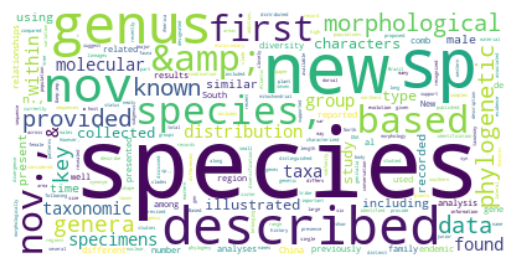

In [14]:
wordcloud_abstracts_json(all_journals, "tax_nomen_phyl_journals")

# Look for taxa in concepts
trying: insect orders from red list (directly with wikidata codes never works, need openalex id) (try http://api.openalex.org/works?filter=concepts.wikidata:https://www.wikidata.org/wiki/Q26371)

Coleoptera: /

Hemiptera: http://api.openalex.org/works?filter=concepts.id:C2778908745

Diptera: /

Lepidoptera: /

Orthoptera: http://api.openalex.org/works?filter=concepts.id:C2778907336

Odonata: http://api.openalex.org/works?filter=concepts.id:C2781015247

Blattodea: http://api.openalex.org/works?filter=concepts.id:C2776009955

Ephemeroptera: http://api.openalex.org/works?filter=concepts.id:C2778489309

Psocodea: /

Grylloblattodea: /

Neuroptera: http://api.openalex.org/works?filter=concepts.id:C2780577104

Mecoptera: /

Trichoptera: http://api.openalex.org/works?filter=concepts.id:C2779446833

Plecoptera: /

Dermaptera: /

Mantodea: http://api.openalex.org/works?filter=concepts.id:C2779688209

Siphonaptera: http://api.openalex.org/works?filter=concepts.id:C2777786777

Strepsiptera: /

Embioptera: /

Hymenoptera: http://api.openalex.org/works?filter=concepts.id:C2780653484

Phasmida: (actually Phasmatoda) /

Raphidioptera: /

Isoptera: /

Megaloptera: /

Thysanoptera: /

Zygentoma: /

Mantophasmatodea: /

Archaeognatha: /

Zoraptera: /

In [8]:
hemiptera = request_pubs_openalex("concepts.id:", "C2778908745")
hemiptera

Number of publications associated with "Hemiptera": 22304


,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,open_access,...,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,https://openalex.org/W2595220198,https://doi.org/10.1099/jgv.0.000738,ICTV Virus Taxonomy Profile: Geminiviridae,ICTV Virus Taxonomy Profile: Geminiviridae,2017,2017-02-01,{'openalex': 'https://openalex.org/W2595220198...,"{'id': 'https://openalex.org/V103035011', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'hybrid', 'oa_url...",...,"[{'id': 'https://openalex.org/V103035011', 'di...","[https://openalex.org/W1971075914, https://ope...","[https://openalex.org/W1977159985, https://ope...",https://api.openalex.org/works/W2595220198/ngrams,"{'The': [0], 'geminiviruses': [1], 'are': [2, ...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2023-01-20T04:26:11.909156,2017-03-23,NaN
1,https://openalex.org/W2145461927,https://doi.org/10.1146/annurev-ento-120811-15...,Biology and Management of Asian Citrus Psyllid...,Biology and Management of Asian Citrus Psyllid...,2013,2013-01-14,{'openalex': 'https://openalex.org/W2145461927...,"{'id': 'https://openalex.org/V92576693', 'issn...",journal-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"[{'id': 'https://openalex.org/V92576693', 'dis...","[https://openalex.org/W184443415, https://open...","[https://openalex.org/W1992690389, https://ope...",https://api.openalex.org/works/W2145461927/ngrams,"{'The': [0], 'Asian': [1], 'citrus': [2, 15, 3...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 4}, {'year':...",2023-01-31T07:23:16.629365,2016-06-24,NaN
2,https://openalex.org/W2170438129,https://doi.org/10.1186/s13059-014-0521-0,Genomes of the rice pest brown planthopper and...,Genomes of the rice pest brown planthopper and...,2014,2014-12-03,{'openalex': 'https://openalex.org/W2170438129...,"{'id': 'https://openalex.org/V81160022', 'issn...",journal-article,"{'is_oa': True, 'oa_status': 'gold', 'oa_url':...",...,"[{'id': 'https://openalex.org/V81160022', 'dis...","[https://openalex.org/W22481580, https://opena...","[https://openalex.org/W35793803, https://opena...",https://api.openalex.org/works/W2170438129/ngrams,"{'The': [0], 'brown': [1, 86, 220], 'planthopp...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 1}, {'year':...",2023-01-25T20:49:25.106025,2016-06-24,NaN
3,https://openalex.org/W2075215526,https://doi.org/10.1111/eea.12025,"Asian citrus psyllid,<i>Diaphorina citri</i>, ...","Asian citrus psyllid,<i>Diaphorina citri</i>, ...",2013,2013-02-01,{'openalex': 'https://openalex.org/W2075215526...,"{'id': 'https://openalex.org/V26596028', 'issn...",journal-article,"{'is_oa': True, 'oa_status': 'bronze', 'oa_url...",...,"[{'id': 'https://openalex.org/V26596028', 'dis...","[https://openalex.org/W201519924, https://open...","[https://openalex.org/W1578899359, https://ope...",https://api.openalex.org/works/W2075215526/ngrams,"{'The': [0, 113], 'Asian': [1, 45], 'citrus': ...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 1}, {'year':...",2023-01-29T06:19:54.956576,2016-06-24,NaN
4,https://openalex.org/W2155621737,https://doi.org/10.1603/ipm14002,"Biology, Ecology, and Management of Brown Marm...","Biology, Ecology, and Management of Brown Marm...",2014,2014-09-01,{'openalex': 'https://openalex.org/W2155621737...,"{'id': 'https://openalex.org/V2734996914', 'is...",journal-article,"{'is_oa': True, 'oa_status': 'gold', 'oa_url':...",...,"[{'id': 'https://openalex.org/V2734996914', 'd...","[https://openalex.org/W92308555, https://opena...","[https://openalex.org/W2015243873, https://ope...",https://api.openalex.org/works/W2155621737/ngrams,"{'Brown': [0], 'marmorated': [1], 'stink': [2,...",https://api.openalex.org/works?filter=cites:W2...,"[{'y

In [9]:
hemiptera.to_pickle("./data/hemiptera_articles.pkl")

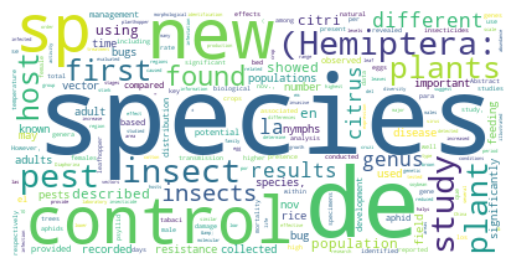

In [12]:
wordcloud_abstracts_json(hemiptera, "wordcloud_hemiptera_concept")

# Look for insect orders (new species) in abstracts (or titles or full text)

Coleoptera: # Look for taxa in concepts
trying: insect orders from red list (directly with wikidata codes never works, need openalex id) (try http://api.openalex.org/works?filter=concepts.wikidata:https://www.wikidata.org/wiki/Q26371)

Coleoptera: https://api.openalex.org/works?filter=abstract.search:(coleoptera%20AND%20%22new%20species%22)

Hemiptera: https://api.openalex.org/works?filter=abstract.search:(hemiptera%20AND%20%22new%20species%22)

better: https://api.openalex.org/works?search=(hemiptera%20AND%20%22new%20species%22)

Diptera: https://api.openalex.org/works?filter=abstract.search:(diptera%20AND%20%22new%20species%22)

etc...

In [24]:
insect_orders = ["Coleoptera", "Hemiptera", "Diptera", "Lepidoptera", "Orthoptera", 
                 "Odonata", "Blattodea", "Ephemeroptera", "Psocodea", "Grylloblattodea", 
                 "Neuroptera", "Mecoptera", "Trichoptera", "Plecoptera", "Dermaptera", 
                 "Mantodea", "Siphonaptera", "Strepsiptera", "Embioptera", "Hymenoptera",
                 "Phasmida", "Raphidioptera", "Isoptera", "Megaloptera", "Thysanoptera",
                 "Zygentoma", "Mantophasmatodea", "Archaeognatha", "Zoraptera"]
insect_articles = pd.DataFrame()

for order in insect_orders:
    order_articles = search_pubs_openalex("("+order+" AND \"new species\")")
    order_articles["order"] = order
    print(order + " done")
    
    insect_articles = pd.concat([insect_articles, order_articles])

insect_articles

Coleoptera done
Hemiptera done
Diptera done
Lepidoptera done
Orthoptera done
Odonata done
Blattodea done
Ephemeroptera done
Psocodea done
Grylloblattodea done
Neuroptera done
Mecoptera done
Trichoptera done
Plecoptera done
Dermaptera done
Mantodea done
Siphonaptera done
Strepsiptera done
Embioptera done
Hymenoptera done
Phasmida done
Raphidioptera done
Isoptera done
Megaloptera done
Thysanoptera done
Zygentoma done
Mantophasmatodea done
Archaeognatha done
Zoraptera done


,id,doi,title,display_name,relevance_score,publication_year,publication_date,ids,host_venue,type,...,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated,order
0,https://openalex.org/W2923200093,None,Further notes on Australian Coleoptera with de...,Further notes on Australian Coleoptera with de...,279.08148,2016,2016-07-02,{'openalex': 'https://openalex.org/W2923200093...,"{'id': None, 'issn_l': None, 'issn': None, 'di...",book,...,[],"[https://openalex.org/W572957188, https://open...",https://api.openalex.org/works/W2923200093/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2020, 'cited_by_count': 2}, {'year':...",2023-01-27T21:49:10.994896,2019-04-01,NaN,Coleoptera
1,https://openalex.org/W2895970952,https://doi.org/10.3161/00034541anz2018.68.3.010,The<i>Cis multidentatus</i>Species-Group (Cole...,The<i>Cis multidentatus</i>Species-Group (Cole...,176.39905,2018,2018-10-08,{'openalex': 'https://openalex.org/W2895970952...,"{'id': 'https://openalex.org/V24891482', 'issn...",journal-article,...,"[https://openalex.org/W108158877, https://open...","[https://openalex.org/W2003951640, https://ope...",https://api.openalex.org/works/W2895970952/ngrams,"{'Cis': [0, 5, 25, 101, 129, 146, 158, 184, 20...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 2}, {'year':...",2023-01-30T18:01:22.329570,2018-10-26,NaN,Coleoptera
2,https://openalex.org/W2759820149,https://doi.org/10.1146/annurev-ento-020117-04...,How Many Species of Insects and Other Terrestr...,How Many Species of Insects and Other Terrestr...,150.51698,2018,2018-01-11,{'openalex': 'https://openalex.org/W2759820149...,"{'id': 'https://openalex.org/V92576693', 'issn...",journal-article,...,"[https://openalex.org/W306638812, https://open...","[https://openalex.org/W1981422546, https://ope...",https://api.openalex.org/works/W2759820149/ngrams,"{'In': [0], 'the': [1, 19, 30, 69, 120], 'last...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 9}, {'year':...",2023-01-25T20:04:19.074824,2017-10-06,NaN,Coleoptera
3,https://openalex.org/W2516041128,https://doi.org/10.3897/zookeys.610.9361,Twelve new species and fifty-three new provinc...,Twelve new species and fifty-three new provinc...,141.47995,2016,2016-08-11,{'openalex': 'https://openalex.org/W2516041128...,"{'id': 'https://openalex.org/V199213172', 'iss...",journal-article,...,"[https://openalex.org/W1964889809, https://ope...","[https://openalex.org/W1992974445, https://ope...",https://api.openalex.org/works/W2516041128/ngrams,"{'One': [0], 'hundred': [1], 'twenty': [2], 's...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 10}, {'year'...",2023-01-20T00:12:05.803217,2016-09-16,NaN,Coleoptera
4,https://openalex.org/W2911258791,https://doi.org/10.11646/zootaxa.4555.2.1,The Onthophagus fuscus (Coleoptera: Scarabaeid...,The Onthophagus fuscus (Coleoptera: Scarabaeid...,138.39027,2019,2019-02-12,{'openalex': 'https://openalex.org/W2911258791...,"{'id': 'https://openalex.org/V171471881', 'iss...",journal-article,...,[],"[https://openalex.org/W1600544125, https://ope...",https://api.openalex.org/works/W2911258791/ngrams,"{'The': [0, 78], 'Onthophagus': [1, 60, 69], '...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 2}, {'year':...",2023-01-19T15:35:34.554999,2019-02-21,NaN,Coleoptera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,https://openalex.org/W4256060135,https://doi.org/10.1111/aen.12238,"Myrmecia: Volume 52, Part 3","Myrmecia: Volume 52, Part 3",1.00000,2016,2016-08-01,{'openalex': 'https://openalex.org/W4256060135...,"{'id': 'https://openalex.org/V4210180117', 'is...",journal-article,...,[],"[https://openalex.org/W224613156, https://open...",https://api.openalex.org/works/W4256060135/ngrams,None,https://api.openalex.or

In [26]:
insect_articles.to_pickle("./data/insect_articles_search.pkl")

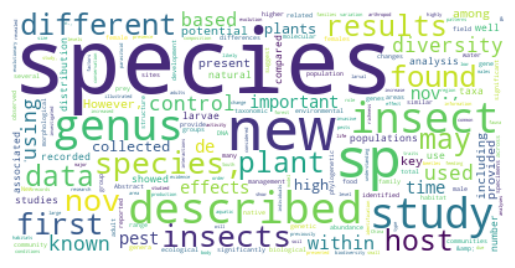

In [27]:
wordcloud_abstracts_json(insect_articles, "wordcloud_insect_orders_search_abstract")

In [25]:
# convert to RLI 
order_freqs = {}

for order in insect_orders:
    count = len(insect_articles[insect_articles["order"]==order].index)
    order_freqs[order] =  count

order_freqs

{'Coleoptera': 16074,
 'Hemiptera': 9289,
 'Diptera': 13737,
 'Lepidoptera': 11878,
 'Orthoptera': 3288,
 'Odonata': 2121,
 'Blattodea': 737,
 'Ephemeroptera': 2076,
 'Psocodea': 228,
 'Grylloblattodea': 79,
 'Neuroptera': 1206,
 'Mecoptera': 298,
 'Trichoptera': 2339,
 'Plecoptera': 1616,
 'Dermaptera': 472,
 'Mantodea': 339,
 'Siphonaptera': 392,
 'Strepsiptera': 207,
 'Embioptera': 103,
 'Hymenoptera': 12061,
 'Phasmida': 117,
 'Raphidioptera': 109,
 'Isoptera': 830,
 'Megaloptera': 306,
 'Thysanoptera': 1336,
 'Zygentoma': 163,
 'Mantophasmatodea': 78,
 'Archaeognatha': 114,
 'Zoraptera': 96}

Replicate RLIT: https://www.webofscience.com/wos/woscc/summary/275e564d-5643-4b79-9cc8-81edfb041af7-6dc7accd/relevance/1